In [2]:
import numpy as np
from scipy.io import loadmat
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from collections import deque
from pinkrigs_tools.dataset.query import load_data, queryCSV
from scipy.ndimage import gaussian_filter1d
import os
import glob

In [3]:

subject_id = 'GB012'
date = '2024-07-16'
exp_kwargs = {
    'subject': subject_id,
    'expDate': date,
    }


BODYPARTS = ['neck', 'mid_back', 'mouse_center', 'mid_backend', 'mid_backend2', 'mid_backend3']

video_path = f"H:/Annotated_Videos/annotated_video_{subject_id}_{date}.mp4"







In [4]:
# LOADING BEHAVIORAL  DATA

def load_specific_experiment_data(subject_id, date):
    # Load only specified components
    data = load_data(
    subject=subject_id,
    expDate=date,
    data_name_dict= 'all-default',
    )
        
    return data

def get_experiment_path(data):
    exp_idx = data.index[data.expDef.isin(['spontaneousActivity'])][0]
    exp_folder = data.loc[exp_idx, 'expFolder']
    exp_num = data.loc[exp_idx, 'expNum']
    return exp_folder, exp_num

def get_timestamps(exp_kwargs, rigName='poppy-stim'):
    data_name_dict = {'topCam':{'camera':['times','ROIMotionEnergy']}}
    recordings = load_data(data_name_dict=data_name_dict,**exp_kwargs)
    stim_recordings = recordings[recordings['rigName'] == rigName]
    timestamps = stim_recordings['topCam'].iloc[0]['camera'].times
    start_time = np.where(timestamps >=0)[0][0]
    timestamps[:start_time] = np.nan
    timestamps = timestamps.flatten()
    
    return start_time, timestamps

def load_video(subject_id, date): 
    cap = cv2.VideoCapture(fr'\\znas\Lab\Share\Maja\labelled_DLC_videos\{subject_id}_{date}.mp4')
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)) 
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    return cap, frame_width, frame_height, fps

def get_DLC_data (subject_id, date, start_time):
        dlc_df = pd.read_hdf(fr'\\znas\Lab\Share\Maja\labelled_DLC_videos\{subject_id}_{date}DLC_resnet50_downsampled_trialJul11shuffle1_150000_filtered.h5')
        dlc_df = dlc_df.iloc[start_time:]
        scorer = dlc_df.columns.get_level_values('scorer')

        return dlc_df, scorer

def get_rotary_metadata(exp_path, bin_centers):
        try:
            TICKS_PER_CYCLE = 1024
            rotary = np.load(os.path.join(exp_path, 'rotaryEncoder.raw.npy'), allow_pickle=True)
            rotary = rotary.flatten()
            rotary[rotary > 2**31] = rotary[rotary > 2**31] - 2**32
            
            timeline_file = glob.glob(os.path.join(exp_path, f'*_Timeline.mat'))[0]   
            time = loadmat(timeline_file)
            rotary_timestamps = time['Timeline']['rawDAQTimestamps'].item()[0, :]
            rotary_position = 360* rotary / (TICKS_PER_CYCLE*4)
            rotary_position = np.unwrap(rotary_position * np.pi/180) * 180/np.pi 
            #binned_rotary_position = np.interp(bin_centers,rotary_timestamps, unwrapped_rotary_position)

            return rotary_timestamps, rotary_position
            

        except Exception as e:
            print(f"Error accessing {exp_path}: {e}")
            
        return None, None

In [11]:
# CALCULATING POSITION AND VELOCITY

def calculate_median_position(dlc_df, scorer):


    # Group by bodyparts and filter for only the ones we want to use in our calculation
    selected_data = dlc_df.loc[:, (scorer, BODYPARTS, slice(None))]
    

    # Select Values of High Quality
    likelihood_values = selected_data.xs('likelihood', level='coords', axis=1)
    likelihood_values[likelihood_values <= 0.95] = np.nan
    likelihood_values = likelihood_values.interpolate(method='linear')
    strong_xs = selected_data.xs('x', level='coords', axis=1)
    strong_ys = selected_data.xs('y', level='coords', axis=1)
    x_medians = strong_xs.median(axis=1)
    y_medians = strong_ys.median(axis=1)
   
    median_position = {idx: {'x': x, 'y': y} for idx, (x, y) in enumerate(zip(x_medians, y_medians))}
    median_position_df = pd.DataFrame.from_dict(median_position, orient='index')
    return median_position_df, x_medians, y_medians


def calculate_velocity(median_positions_df, fps):
    # Calculate the velocity using the binned median positions
    distances = np.sqrt(np.diff(median_positions_df, axis=0)**2).sum(axis=1)
    max_distance = np.percentile(distances, 99)  
    distances[distances > max_distance] = np.nan
    valid_indices = np.where(~np.isnan(distances))[0]
    distances = np.interp(
    np.arange(len(distances)),  
    valid_indices,              
    distances[valid_indices]    
)
    velocity_pix = distances / (1/fps)
    conversion_factor = 0.07
    velocity = velocity_pix * conversion_factor
    velocity = gaussian_filter1d(velocity, 3)
    velocity = np.concatenate(([velocity[0] if len(velocity) > 0 else 0], velocity)) 
    return velocity



def calculate_wheel_velocity(rotary_timestamps, timestamps, rotary_position,start_time, wheel_diameter=15.5):
    wheel_circumference = np.pi * wheel_diameter
    linear_distance_cm = np.diff(rotary_position) * wheel_circumference / 360 
    wheel_velocity = np.abs(linear_distance_cm / np.diff(rotary_timestamps)) 
    wheel_velocity = gaussian_filter1d(wheel_velocity, 3)
    wheel_velocity = np.concatenate(([wheel_velocity[0] if len(wheel_velocity) > 0 else 0], wheel_velocity))
    wheel_velocity = np.interp(timestamps, rotary_timestamps, wheel_velocity)
    wheel_velocity = wheel_velocity[start_time:]
    return wheel_velocity

In [6]:


def initialize_labeled_video (cap, start_time, frame_width, frame_height, fps, video_path, plot_height=200):
    cap.set(cv2.CAP_PROP_POS_FRAMES, start_time)

    labeled_video = cv2.VideoWriter(video_path,
                                                cv2.VideoWriter_fourcc(*'mp4v'),
                                                fps, 
                                                (frame_width, frame_height + plot_height*2))
                                        
    return labeled_video

def process_frame(frame, frame_idx, median_position_df, center_x, center_y, radius): 
    frame = frame.copy()
    cv2.circle(frame, (int(median_position_df[frame_idx, 0]),int( median_position_df[frame_idx, 1])), 5, (255, 0, 0), -1)
    cv2.circle(frame, (center_x, center_y), radius, (0, 255, 0), 2)
    cv2.circle(frame, (center_x, center_y), 5, (0, 0, 255), -1)

    return frame



In [12]:
def get_ROI(subject_id, date):
    frame_idx = 0

    cap = cv2.VideoCapture(fr'\\znas\Lab\Share\Maja\labelled_DLC_videos\{subject_id}_{date}.mp4')
    while frame_idx < 3000: 

        ret, frame = cap.read()
        if not ret:
            break
        frame_idx += 1
        
        preprocessed_frame = preprocess_frame(frame)
        circles = cv2.HoughCircles(preprocessed_frame, cv2.HOUGH_GRADIENT, dp=1.5, param1=50, param2= 20,minDist=90, minRadius=104, maxRadius=110)

        xy_list = []
        r_list = []
        if circles is not None:
            
            # Convert the (x, y) coordinates and radius of the circles to integers
            circles = np.uint16(np.around(circles))
            x, y, r = circles[0][0]
            xy_list.append((x, y))
            r_list.append(r)

        if frame_idx % 100 == 0:
            print(f"Processing frame {frame_idx}/3000")

    cap.release()
    cv2.destroyAllWindows()

    if len(xy_list) == 0:
        print("No circles found in the video.")
        return None, None, None, None
    
    # Get ROI center and radius
    center_x = int(np.median([xy[0] for xy in xy_list]))
    center_y = int(np.median([xy[1] for xy in xy_list]))
    radius = int(np.median(r_list))

    return frame, center_x, center_y, radius
        
        

def preprocess_frame(frame):
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    preprocessed_frame = cv2.medianBlur(gray_frame, 21)
    return preprocessed_frame

def plot_ROI(frame, center_x, center_y, radius):
    # Draw the circle in the image
    cv2.circle(frame, (center_x, center_y), radius, (0, 255, 0), 2)
    # Draw a rectangle at the center of the circle
    cv2.circle(frame, (center_x, center_y), 2, (0, 255, 0), -1)

    #show results
    plt.figure(figsize=(10, 8))
    plt.title(f'{subject_id}-{date}: center: ({center_x}, {center_y}), radius: {radius}')
    plt.imshow(frame)

def get_mask (binned_x, binned_y, center_x, center_y, radius, subject_id):
    distances = np.sqrt((binned_x - center_x) ** 2 + (binned_y - center_y) ** 2)

    wheel_mask = distances <= radius
    wheel_mask = temporal_buffer(wheel_mask, buffer_size=5)

    
    right_corner =(
        (binned_x > center_x ) &  
        (binned_y > center_y)
    )

    left_corner = (
        (binned_x < center_x ) &  
        (binned_y < center_y)
    )   

    if not subject_id == 'GB012':
        arena_mask = ~wheel_mask & (~right_corner)

    else:
        arena_mask = ~wheel_mask & (~left_corner)

    return arena_mask, wheel_mask

def temporal_buffer(mask,  buffer_size=5):
    state_mask = mask.copy()
    prev_state = state_mask[0]
    new_state = 0 

    for i in range(1, len(state_mask)):
        if state_mask[i] != prev_state:

            if i -new_state < buffer_size:
                state_mask[new_state:i] = prev_state

            else:
                prev_state = state_mask[i]
                new_state = i

    if len(state_mask) - new_state < buffer_size:
        state_mask[new_state:] = prev_state
        
    return state_mask
    
            




    

    

    




In [ ]:
def initialize_plots (frame_width, velocity, wheel_velocity, window_size= 180, plot_height=200):

    x_window = deque(maxlen=window_size)
    OA_window = deque(maxlen=window_size)
    WH_window = deque(maxlen=window_size)

    fig_OA = plt.figure(figsize=(frame_width/100, plot_height/100))
    ax_OA = fig_OA.add_subplot(111)
    ax_OA.set_xlim(0, window_size)
    ax_OA.set_ylim(0, np.nanmax(velocity))
    ax_OA.set_title('OA')
    ax_OA.set_xlabel('Time (s)')
    ax_OA.set_ylabel('Velocity (cm/s)')
    line_OA = ax_OA.plot([], [], color='blue')[0]

    fig_WH = plt.figure(figsize=(frame_width/100, plot_height/100))
    ax_WH = fig_WH.add_subplot(111)
    ax_WH.set_xlim(0, window_size)
    ax_WH.set_ylim(0, np.nanmax(wheel_velocity))
    ax_WH.set_title('Wheel')
    ax_WH.set_xlabel('Time (s)')
    ax_WH.set_ylabel('Velocity (cm/s)')
    line_WH = ax_WH.plot([], [], color='red')[0]

    fig_OA.tight_layout()
    fig_WH.tight_layout()

    return fig_OA, ax_OA, line_OA, fig_WH, ax_WH, OA_window,x_window, WH_window, line_WH

def update_plots (fig_OA, ax_OA, line_OA, fig_WH, ax_WH, line_WH, x_window, OA_window, WH_window, velocity, wheel_velocity, frame_idx, frame_width, plot_height=200):

    x_window.append(frame_idx)
    OA_window.append(velocity[frame_idx])
    WH_window.append(wheel_velocity[frame_idx])

    ax_OA.set_xlim(frame_idx - len(OA_window), frame_idx)
    ax_WH.set_xlim(frame_idx - len(WH_window), frame_idx)

    line_OA.set_data(x_window, OA_window)
    line_WH.set_data(x_window, WH_window)

    fig_OA.canvas.draw()
    fig_WH.canvas.draw()

    # convert the figures to images
    img_OA = np.frombuffer(fig_OA.canvas.tostring_argb(), dtype=np.uint8)
    img_OA = img_OA.reshape(fig_OA.canvas.get_width_height()[::-1] + (4,)) 
    img_OA = cv2.cvtColor(img_OA, cv2.COLOR_RGB2BGR)
    img_OA = cv2.resize(img_OA, (frame_width, plot_height))
    
    img_WH = np.frombuffer(fig_WH.canvas.tostring_argb(), dtype=np.uint8)
    img_WH = img_WH.reshape(fig_WH.canvas.get_width_height()[::-1] + (4,))
    img_WH = cv2.cvtColor(img_WH, cv2.COLOR_RGB2BGR)
    img_WH = cv2.resize(img_WH, (frame_width, plot_height))
    
    return img_OA, img_WH

def concatenate_frames(frame, img_OA, img_WH):
    combined_frame = np.vstack((frame, img_OA, img_WH))
    return combined_frame


def data_loading (subject_id, date, exp_kwargs):
    data = load_specific_experiment_data(subject_id, date)
    frame, center_x, center_y, radius = get_ROI(subject_id, date)
    plot_ROI(frame, center_x, center_y, radius)
    exp_path, exp_num = get_experiment_path(data)
    start_time, timestamps = get_timestamps(exp_kwargs)
    dlc_df, scorer = get_DLC_data(subject_id, date, start_time)
    median_position_df, x_medians, y_medians = calculate_median_position(dlc_df, scorer)
    median_position_df = median_position_df.to_numpy()
    arena_mask, wheel_mask = get_mask(median_position_df, center_x, center_y, radius)
    arena_mask = temporal_buffer(arena_mask, buffer_size=5)
    wheel_mask = temporal_buffer(wheel_mask, buffer_size=5)
    cap, frame_width, frame_height, fps = load_video(subject_id, date)
    velocity = calculate_velocity(median_position_df, fps)
    velocity[~arena_mask] = np.nan
    rotary_timestamps, rotary_position = get_rotary_metadata(exp_path, timestamps)
    wheel_velocity = calculate_wheel_velocity(rotary_timestamps, timestamps, rotary_position, start_time)
    wheel_velocity[~wheel_mask] = np.nan
    print(len(np.where(np.isnan(wheel_velocity))))
    labeled_video = initialize_labeled_video(cap, start_time, frame_width, frame_height, fps, video_path, plot_height=200)
    fig_OA, ax_OA, line_OA, fig_WH, ax_WH, OA_window,x_window, WH_window, line_WH = initialize_plots(frame_width, velocity, wheel_velocity, window_size=180, plot_height=200)

    return cap, median_position_df, velocity, wheel_velocity, labeled_video, fig_OA, ax_OA, line_OA, fig_WH, ax_WH, OA_window,x_window, WH_window, line_WH, frame_width,x_medians, y_medians, center_x, center_y, radius

def main(cap, median_position_df, velocity, wheel_velocity, labeled_video, fig_OA, ax_OA, line_OA, fig_WH, ax_WH, OA_window,x_window, WH_window, line_WH, frame_width, center_x, center_y, radius):
    for frame_idx in range(len(median_position_df)):
        ret, frame = cap.read()
        if not ret:
            break
        frame = process_frame(frame, frame_idx, median_position_df, center_x, center_y, radius)
        img_OA, img_WH = update_plots(fig_OA, ax_OA, line_OA, fig_WH, ax_WH, line_WH, x_window, OA_window, WH_window, velocity, wheel_velocity, frame_idx, frame_width)
        combined_frame = concatenate_frames(frame, img_OA, img_WH)
        labeled_video.write(combined_frame)

        if frame_idx % 100 == 0:
            print(f"Processing frame {frame_idx}/{len(median_position_df)}")

        if frame_idx == 250000:
            break
    print("Processing complete.")
    cap.release()
    labeled_video.release()
    cv2.destroyAllWindows()




In [14]:
start_time, timestamps = get_timestamps(exp_kwargs)
print(len(timestamps))

112100


Processing frame 100/3000
Processing frame 200/3000
Processing frame 300/3000
Processing frame 400/3000
Processing frame 500/3000
Processing frame 600/3000
Processing frame 700/3000
Processing frame 800/3000
Processing frame 900/3000
Processing frame 1000/3000
Processing frame 1100/3000
Processing frame 1200/3000
Processing frame 1300/3000
Processing frame 1400/3000
Processing frame 1500/3000
Processing frame 1600/3000
Processing frame 1700/3000
Processing frame 1800/3000
Processing frame 1900/3000
Processing frame 2000/3000
Processing frame 2100/3000
Processing frame 2200/3000
Processing frame 2300/3000
Processing frame 2400/3000
Processing frame 2500/3000
Processing frame 2600/3000
Processing frame 2700/3000
Processing frame 2800/3000
Processing frame 2900/3000
Processing frame 3000/3000


TypeError: get_mask() missing 2 required positional arguments: 'radius' and 'subject_id'

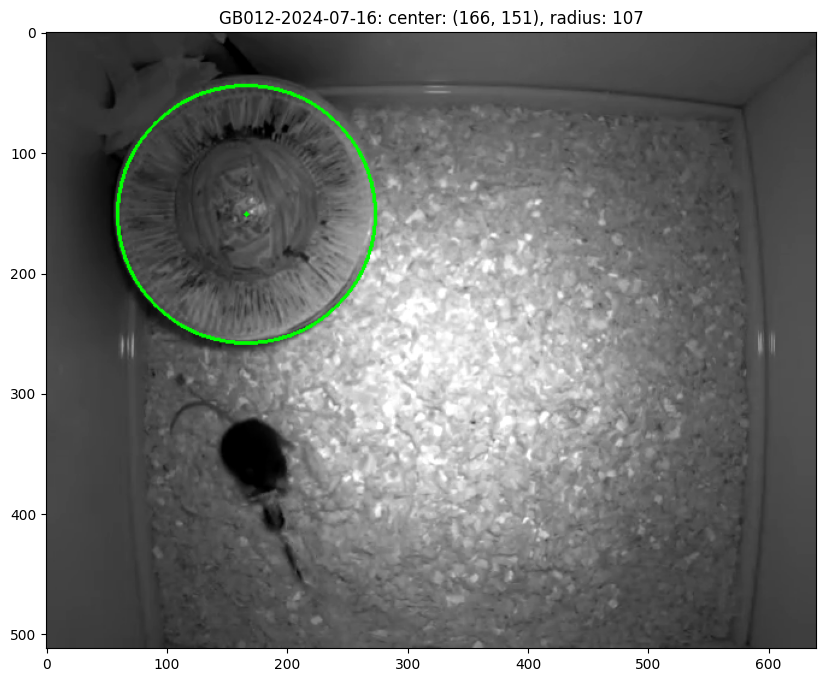

In [15]:
cap, median_position_df, velocity, wheel_velocity, labeled_video, fig_OA, ax_OA, line_OA, fig_WH, ax_WH, OA_window,x_window, WH_window, line_WH, frame_width,x_medians, y_medians, center_x, center_y, radius = data_loading(subject_id, date, exp_kwargs)
main(cap, median_position_df, velocity, wheel_velocity, labeled_video, fig_OA, ax_OA, line_OA, fig_WH, ax_WH, OA_window,x_window, WH_window, line_WH, frame_width, center_x, center_y, radius)
